In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'relu',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

relu_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:32 - loss: 0.1260 - STD: 0.0273 - MAE: 0.3406

 4/64 [>.............................] - ETA: 1s - loss: 0.0469 - STD: 0.0249 - MAE: 0.1671  

 7/64 [==>...........................] - ETA: 1s - loss: 0.0416 - STD: 0.0212 - MAE: 0.1598

10/64 [===>..........................] - ETA: 1s - loss: 0.0348 - STD: 0.0255 - MAE: 0.1439

13/64 [=====>........................] - ETA: 1s - loss: 0.0293 - STD: 0.0320 - MAE: 0.1288

16/64 [======>.......................] - ETA: 1s - loss: 0.0254 - STD: 0.0368 - MAE: 0.1161

19/64 [=======>......................] - ETA: 2s - loss: 0.0233 - STD: 0.0435 - MAE: 0.1079

22/64 [=========>....................] - ETA: 2s - loss: 0.0210 - STD: 0.0491 - MAE: 0.1014

25/64 [==========>...................] - ETA: 1s - loss: 0.0191 - STD: 0.0539 - MAE: 0.0961

28/64 [============>.................] - ETA: 1s - loss: 0.0176 - STD: 0.0585 - MAE: 0.0913

31/64 [=============>................] - ETA: 1s - loss: 0.0163 - STD: 0.0610 - MAE: 0.0870

34/64 [==============>...............] - ETA: 1s - loss: 0.0152 - STD: 0.0637 - MAE: 0.0833

37/64 [================>.............] - ETA: 1s - loss: 0.0143 - STD: 0.0660 - MAE: 0.0801

40/64 [=================>............] - ETA: 0s - loss: 0.0135 - STD: 0.0682 - MAE: 0.0774

43/64 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 0.0700 - MAE: 0.0748

46/64 [====================>.........] - ETA: 0s - loss: 0.0122 - STD: 0.0713 - MAE: 0.0725

49/64 [=====================>........] - ETA: 0s - loss: 0.0117 - STD: 0.0729 - MAE: 0.0704

52/64 [=======================>......] - ETA: 0s - loss: 0.0112 - STD: 0.0743 - MAE: 0.0686

55/64 [========================>.....] - ETA: 0s - loss: 0.0107 - STD: 0.0754 - MAE: 0.0669

58/64 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 0.0764 - MAE: 0.0654

61/64 [===========================>..] - ETA: 0s - loss: 0.0100 - STD: 0.0773 - MAE: 0.0639

64/64 [==============================] - ETA: 0s - loss: 0.0096 - STD: 0.0783 - MAE: 0.0626

64/64 [==============================] - 4s 45ms/step - loss: 0.0096 - STD: 0.0783 - MAE: 0.0626 - val_loss: 0.0044 - val_STD: 0.0748 - val_MAE: 0.0432


Epoch 2/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.1021 - MAE: 0.0359

 4/64 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0971 - MAE: 0.0351

 7/64 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0980 - MAE: 0.0348

10/64 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.0982 - MAE: 0.0346

13/64 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0981 - MAE: 0.0344

16/64 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0980 - MAE: 0.0342

19/64 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0983 - MAE: 0.0341

22/64 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0982 - MAE: 0.0340

25/64 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.0984 - MAE: 0.0338

28/64 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.0986 - MAE: 0.0337

31/64 [=============>................] - ETA: 0s - loss: 0.0026 - STD: 0.0988 - MAE: 0.0335

34/64 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.0991 - MAE: 0.0333

37/64 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0993 - MAE: 0.0332

40/64 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0995 - MAE: 0.0330

43/64 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0997 - MAE: 0.0329

46/64 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0996 - MAE: 0.0329

49/64 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0998 - MAE: 0.0328

52/64 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1001 - MAE: 0.0327

55/64 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1001 - MAE: 0.0326

58/64 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1004 - MAE: 0.0325

61/64 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1004 - MAE: 0.0323

64/64 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1005 - MAE: 0.0322

64/64 [==============================] - 2s 27ms/step - loss: 0.0023 - STD: 0.1005 - MAE: 0.0322 - val_loss: 0.0023 - val_STD: 0.0912 - val_MAE: 0.0327


Epoch 3/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.1083 - MAE: 0.0299

 4/64 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0298

 7/64 [==>...........................] - ETA: 1s - loss: 0.0019 - STD: 0.1027 - MAE: 0.0294

10/64 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0294

13/64 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

16/64 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0330

19/64 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.1029 - MAE: 0.0335

22/64 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0336

25/64 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0336

28/64 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0334

31/64 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0331

34/64 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0329

37/64 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0327

40/64 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0324

42/64 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0323

45/64 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

48/64 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0319

51/64 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0317

54/64 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0315

57/64 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0314

60/64 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0312

63/64 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0311

64/64 [==============================] - 2s 27ms/step - loss: 0.0021 - STD: 0.1030 - MAE: 0.0310 - val_loss: 0.0019 - val_STD: 0.0916 - val_MAE: 0.0295


Epoch 4/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0277

 4/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

 7/64 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0282

10/64 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

13/64 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281

16/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

19/64 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0281

22/64 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0281

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

27/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

30/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

33/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

36/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

39/64 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

45/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0286

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0286

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0286

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0286

64/64 [==============================] - 2s 27ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0286 - val_loss: 0.0021 - val_STD: 0.0951 - val_MAE: 0.0313


Epoch 5/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1095 - MAE: 0.0280

 3/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0279

 6/64 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0287

 9/64 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0285

12/64 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

15/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

18/64 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

21/64 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

24/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

27/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

30/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

33/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

64/64 [==============================] - 2s 27ms/step - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279 - val_loss: 0.0022 - val_STD: 0.0984 - val_MAE: 0.0312


Epoch 6/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0271

 4/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0276

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

16/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

22/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

64/64 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274 - val_loss: 0.0020 - val_STD: 0.0972 - val_MAE: 0.0302


Epoch 7/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

 7/64 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0286

10/64 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0287

13/64 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

16/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0279

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0277

22/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0278

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

64/64 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274 - val_loss: 0.0016 - val_STD: 0.0947 - val_MAE: 0.0277


Epoch 8/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1010 - MAE: 0.0270

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0266

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0272

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0272

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0272

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0272

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0272

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0272

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0272

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270 - val_loss: 0.0017 - val_STD: 0.0964 - val_MAE: 0.0282


Epoch 9/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0256

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0256

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0257

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0257

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0259

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260 - val_loss: 0.0025 - val_STD: 0.1033 - val_MAE: 0.0329


Epoch 10/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1127 - MAE: 0.0269

 4/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0295

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0282

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0271

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0268

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0267

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264 - val_loss: 0.0015 - val_STD: 0.0952 - val_MAE: 0.0272


Epoch 11/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0255

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1051 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0253

10/64 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0252

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0259

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264 - val_loss: 0.0018 - val_STD: 0.0964 - val_MAE: 0.0295


Epoch 12/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

22/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

24/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

27/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

32/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

35/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257 - val_loss: 0.0017 - val_STD: 0.0991 - val_MAE: 0.0279


Epoch 13/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

 7/64 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0249

10/64 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

13/64 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0249

16/64 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0249

19/64 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

22/64 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

28/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0263

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268 - val_loss: 0.0023 - val_STD: 0.1010 - val_MAE: 0.0323


Epoch 14/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0264

 3/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0259

 6/64 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

12/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

18/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

24/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

27/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

33/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

36/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

39/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0252

42/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

45/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

48/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

64/64 [==============================] - 2s 27ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251 - val_loss: 0.0016 - val_STD: 0.0968 - val_MAE: 0.0271


Epoch 15/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0246

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1076 - MAE: 0.0246

 7/64 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

10/64 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0247

13/64 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

16/64 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

19/64 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

22/64 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

28/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0254

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0254

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0255

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

64/64 [==============================] - 2s 26ms/step - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254 - val_loss: 0.0018 - val_STD: 0.0994 - val_MAE: 0.0283


Epoch 16/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1090 - MAE: 0.0243

 4/64 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

 7/64 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0244

10/64 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0245

13/64 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

16/64 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

19/64 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

22/64 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0246

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

28/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

40/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

43/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

64/64 [==============================] - 2s 26ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247 - val_loss: 0.0026 - val_STD: 0.1023 - val_MAE: 0.0344


Epoch 17/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0272

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1078 - MAE: 0.0255

 7/64 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0253

10/64 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

13/64 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

16/64 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

19/64 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

22/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

28/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

40/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

43/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

48/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

64/64 [==============================] - 2s 27ms/step - loss: 0.0012 - STD: 0.1066 - MAE: 0.0246 - val_loss: 0.0023 - val_STD: 0.1030 - val_MAE: 0.0318


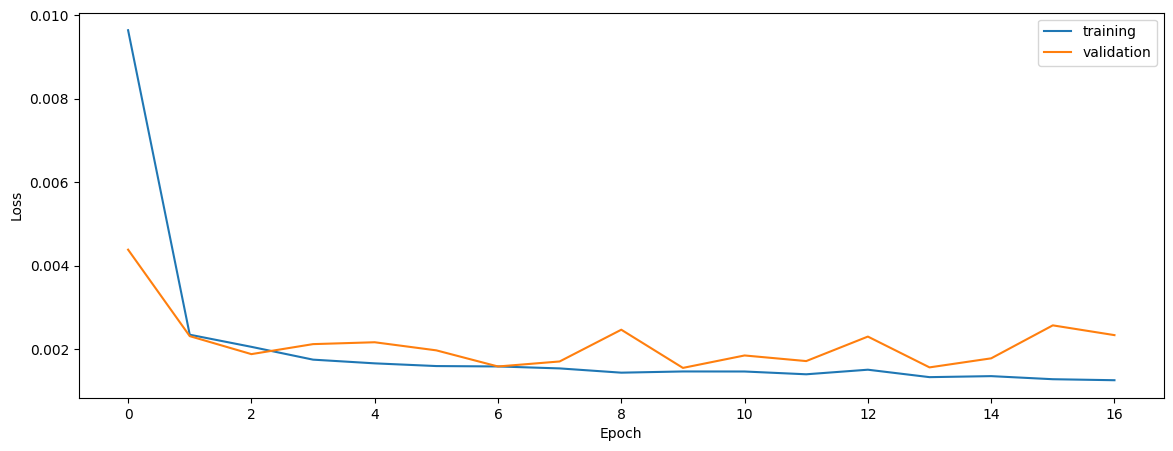

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9455880484727626
0.9546429332303866
0.948807374272557


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9459779026781135
0.9520271382335554
0.9499137167576253


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9527288438779403
0.9539416024601032
0.9617710907148714


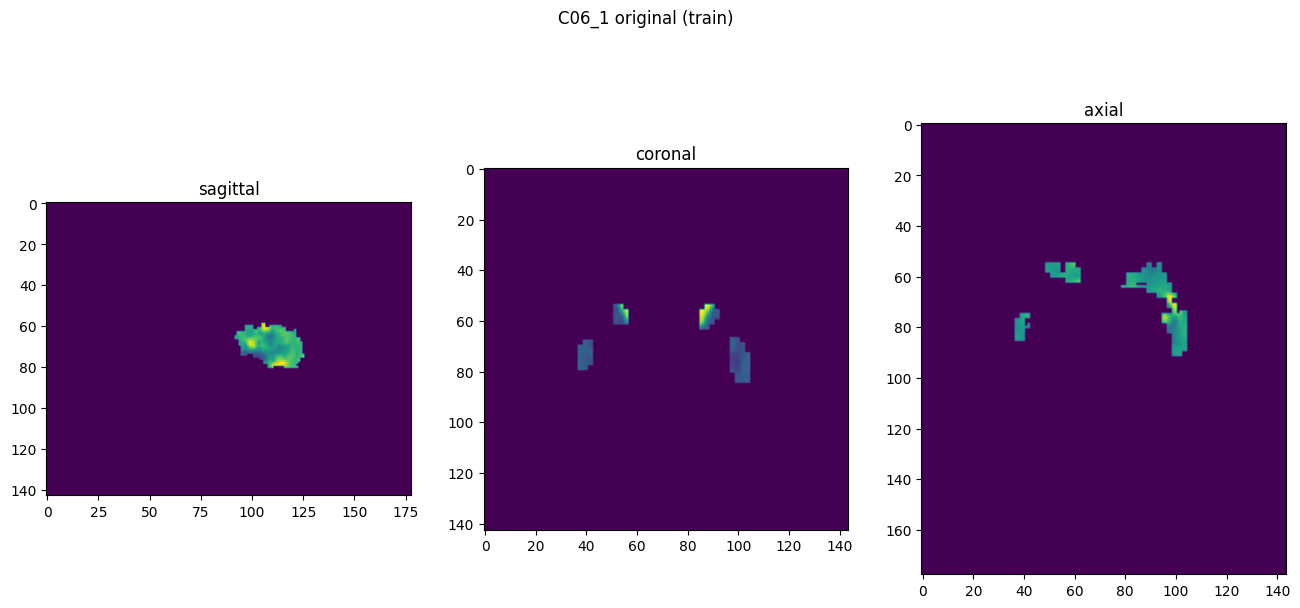

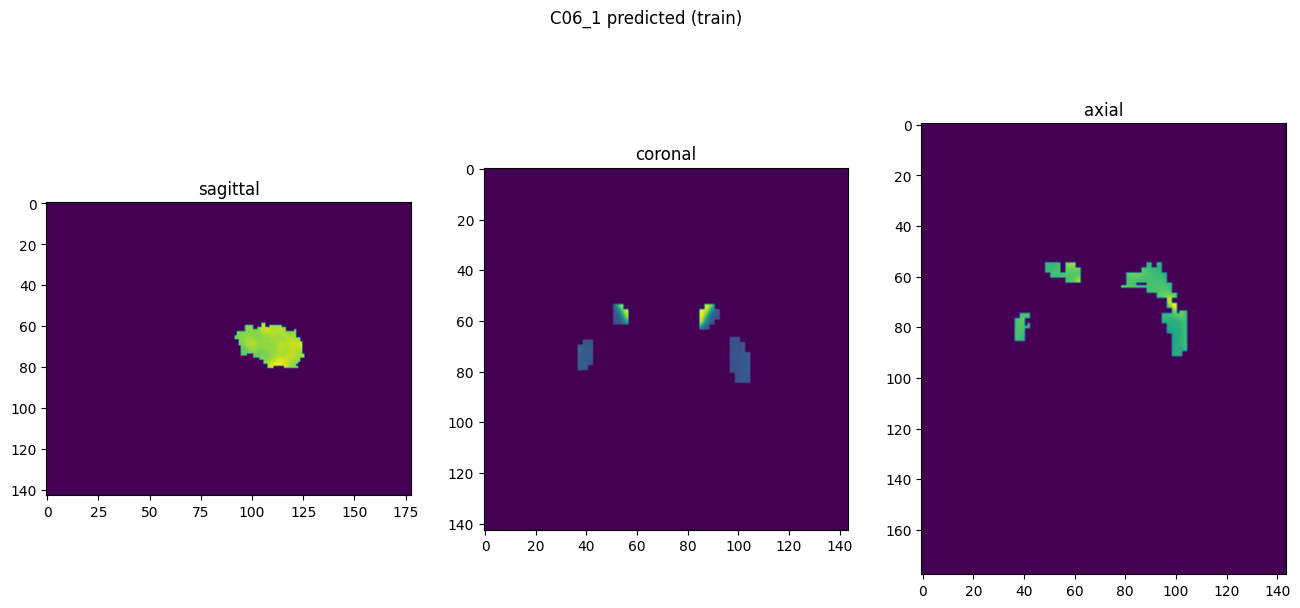

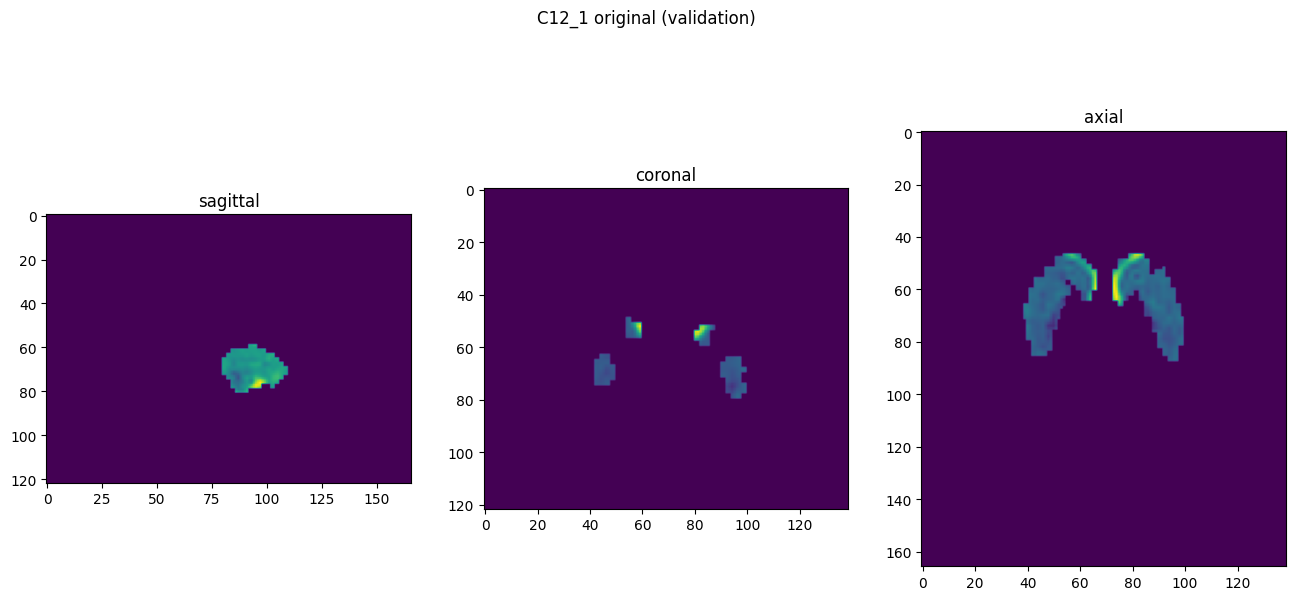

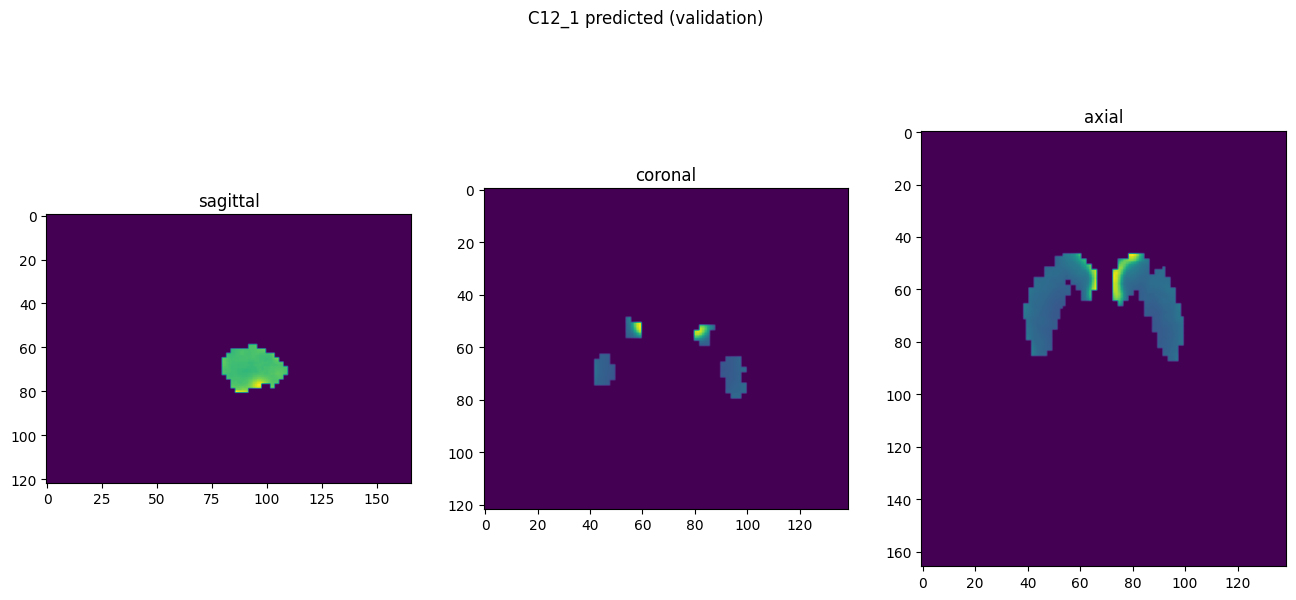

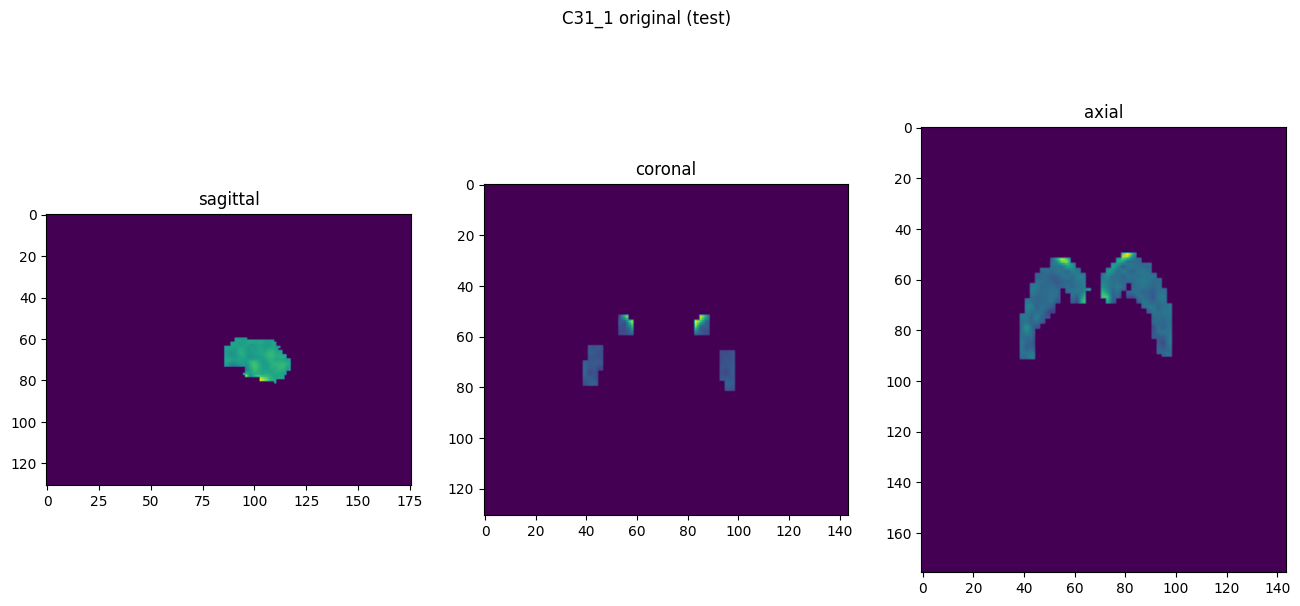

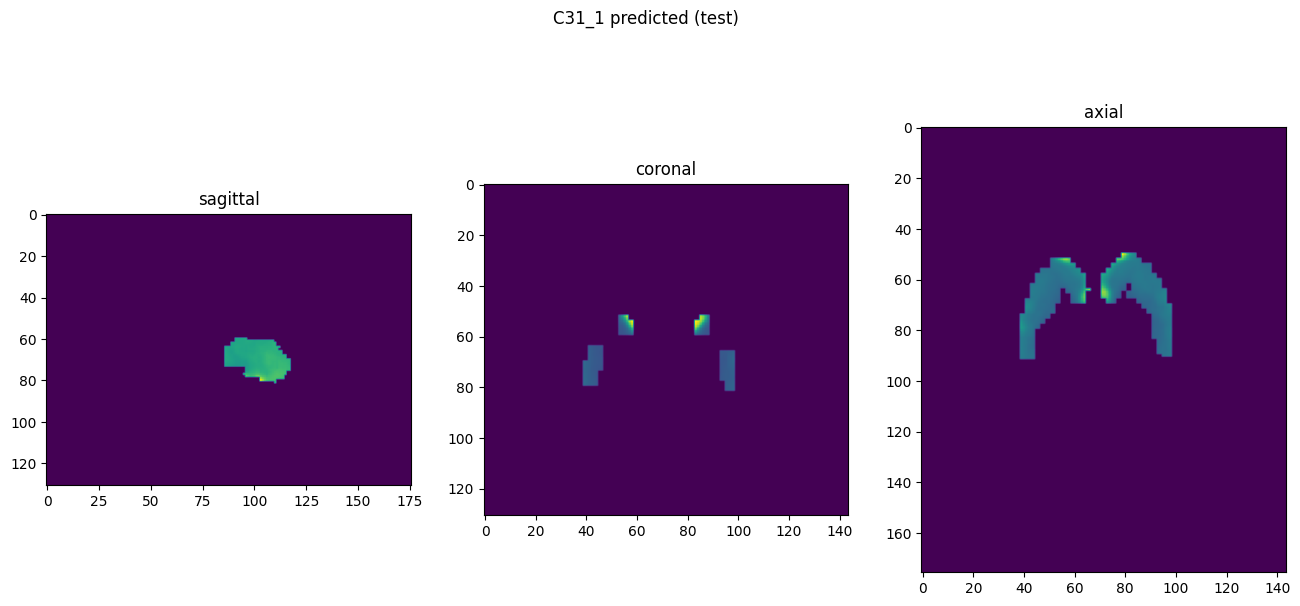

In [10]:
showResults(model, gen, threshold=None, background=False)